# Chapter 8

In [1]:
from PIL import Image
import webgpupy as np
from functools import reduce
from time import time

In [2]:
class Vec3:
    def __new__(cls, x: float=0, y:float=0, z:float=0):
        return np.array([x, y, z], dtype='float32')

Point3=Vec3
Color=Vec3

In [3]:
class VecUtils:
    @staticmethod
    def x(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,0].reshape((image_height, image_width, 1))

    @staticmethod
    def y(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,1].reshape((image_height, image_width, 1))
    
    @staticmethod
    def z(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,2].reshape((image_height, image_width, 1))

    @staticmethod
    def unit_vector(data):
        e0 = VecUtils.x(data)
        e1 = VecUtils.y(data)
        e2 = VecUtils.z(data)
        return data / np.sqrt((e0*e0+e1*e1+e2*e2))
    
    @staticmethod
    def dot(data1, data2):
        data1_x = VecUtils.x(data1)
        data1_y = VecUtils.y(data1)
        data1_z = VecUtils.z(data1)
        data2_x = VecUtils.x(data2)
        data2_y = VecUtils.y(data2)
        data2_z = VecUtils.z(data2)
        return data1_x * data2_x + data1_y * data2_y + data1_z * data2_z

In [4]:
class Rays:
    
    def __init__(self, origin, direction) -> None:
        self.orig = origin
        self.dir = direction

    def origin(self):
        return self.orig

    def direction(self):
        return self.dir

    def at(self, t):
        return self.orig + t*self.dir

In [ ]:
FARAWAY = np.array([1.0e37])
rng = np.random.default_rng()

def convert_to_image(pixels, samples_per_pixel):
    print(pixels.shape)
    pixels = pixels/float(samples_per_pixel)
    pixels = np.clip(pixels, 0.0, 0.999)
    pixels = (pixels * 255.0).astype('uint8')
    pixels = pixels.tolist()
    print(time() - start)
    import numpy
    image_array = numpy.array(pixels, dtype= 'uint8')
    return Image.fromarray(image_array, 'RGB')

In [6]:
class Sphere:
    def __init__(self, center, radius: float) -> None:
        self.radius = radius
        self.center = center
    
    def hit(self, r: Rays):
        oc = r.origin() - self.center
        a = VecUtils.dot(r.direction(), r.direction())
        half_b = VecUtils.dot(oc, r.direction())
        c = VecUtils.dot(oc, oc) - self.radius*self.radius
        discriminant = half_b*half_b - a*c

        sqrtd = np.sqrt(np.maximum(0.0, discriminant))

        root1 = (-half_b - sqrtd) / a
        root2 = (-half_b + sqrtd) / a
        root = np.where((root1 > 0.0) & (root1 < root2), root1, root2)
        pred = (discriminant > 0.0) & (root > 0.0)
        return np.where(pred, root, FARAWAY)

    def color(self, r: Rays, t, hit):
        t = t * hit.astype('float32')
        hit_point = r.at(t)
        outward_normal = (hit_point - self.center) / self.radius
        front_face = VecUtils.dot(r.direction(), outward_normal) < 0.0
        normal = np.where(front_face, outward_normal, -outward_normal)
        normal = np.where(hit, normal, 0.0)
        return normal

class World:
    def __init__(self) -> None:
        self.hittable_list = []

    def add(self, object):
        self.hittable_list.append(object)
    
    def color(self, rays: Rays):
        
        t_values = []

        for object in self.hittable_list:
            t_values.append(object.hit(rays))

        nearest = reduce(np.minimum, t_values)
        image_shape = rays.origin().shape
        color = np.zeros(image_shape)
        for (s, t) in zip(self.hittable_list, t_values):
            hit = (nearest != FARAWAY) & (t == nearest)
            if np.any(hit):
                color += s.color(rays, t, hit)

        return (color, nearest == FARAWAY)
    
class Camera:
    def __init__(self, aspect_ratio, image_width, image_height) -> None:
        viewport_height = 2.0
        viewport_width = aspect_ratio * viewport_height
        focal_length = 1.0

        self.origin = np.zeros((image_height, image_width, 3), dtype='float32')
        self.horizontal = Vec3(viewport_width, 0.0, 0.0)
        self.vertical = Vec3(0.0, viewport_height, 0.0)
        self.lower_left_corner = self.origin - self.horizontal/2.0 - self.vertical/2.0 - Vec3(0.0, 0.0, focal_length)

    def get_ray(self, u, v):
        return Rays(self.origin, self.lower_left_corner + u*self.horizontal + v*self.vertical - self.origin)
        

In [7]:
def random_array(shape):
    return rng.random(shape)

In [8]:
def ray_color(rays: Rays, world):
    (world_color, not_hit) = world.color(rays)
    hit = np.invert(not_hit)
    world_color = 0.5 * (world_color + 1.0) * hit.astype("float32")
    dir = rays.direction()
    unit_direction = VecUtils.unit_vector(dir)
    t = 0.5*(VecUtils.y(unit_direction) + 1.0)
    is_not_hit_color = ((1.0-t)*Color(1.0, 1.0, 1.0) + t*Color(0.5, 0.7, 1.0)) * not_hit.astype("float32")
    return world_color + is_not_hit_color

[720, 1280, 3]
6.332240581512451


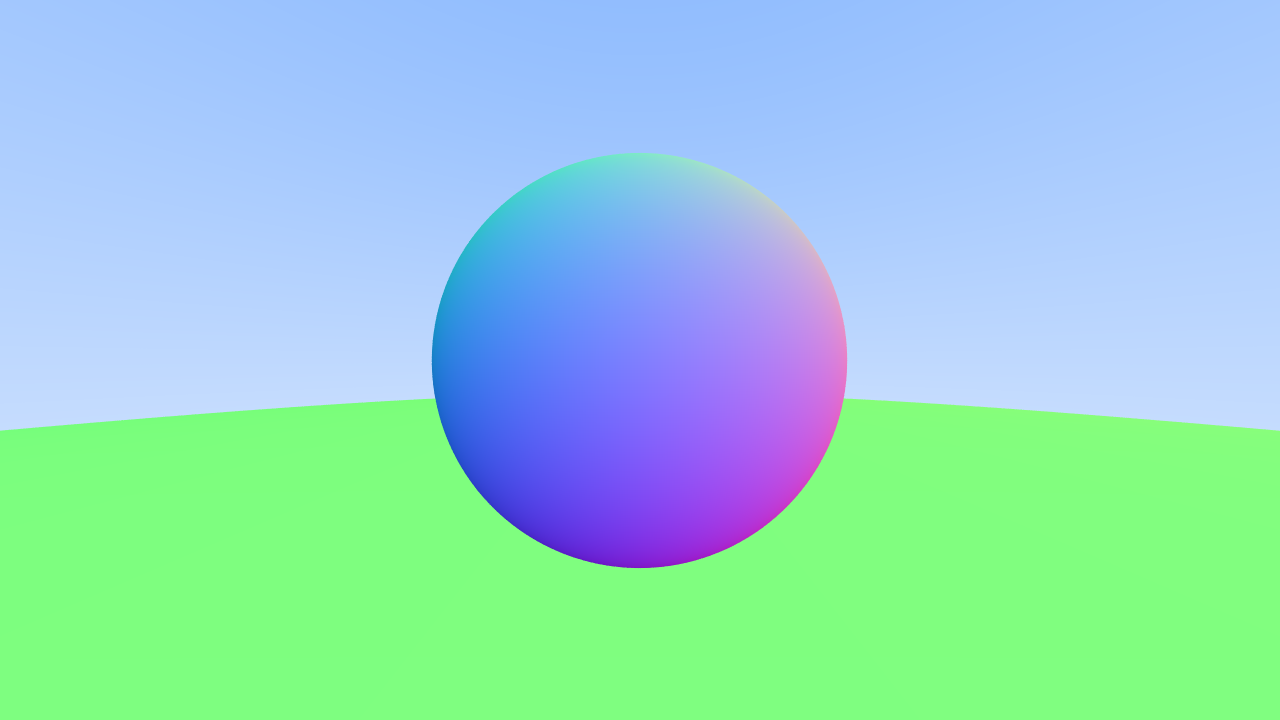

In [9]:
image_height = 720
aspect_ratio = 16/9
image_width = int(image_height * aspect_ratio)
samples_per_pixel = 50
start = time()

u = np.array([[i/(image_width - 1) for i in range(0, image_width)]])
u = np.repeat(u, image_height, axis=0).reshape([image_height, image_width, 1])
v = np.array([i/(image_height - 1) for i in range(image_height-1, -1, -1)]).reshape([image_height, 1])
v = np.repeat(v, image_width, axis=1).reshape([image_height, image_width, 1])

cam = Camera(aspect_ratio, image_width, image_height)

world = World()
world.add(Sphere(Point3(0.0,-100.5,-1.0), 100.0))
world.add(Sphere(Point3(0.0,0.0,-1.0), 0.5))


pixels = np.zeros((image_height, image_width, 3))
for i in range(0, samples_per_pixel):
    new_u = u + (random_array(u.shape) / float(image_width - 1))
    new_v = v + (random_array(v.shape) / float(image_height - 1))
    rays = cam.get_ray(new_u, new_v)
    pixels += ray_color(rays, world)

convert_to_image(pixels, samples_per_pixel)